<a href="https://colab.research.google.com/github/khaled0625/w4_Transfer_Learning/blob/main/Transfer_Learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import os
import torch
from torchvision import datasets, transforms

In [ ]:
import kagglehub
path = kagglehub.dataset_download("mohdrehanhaider/arabic-characters")

Using Colab cache for faster access to the 'arabic-characters' dataset.


In [ ]:
import os
print("REAL FOLDER NAMES:", os.listdir(path))

REAL FOLDER NAMES: ['Arabic Character Dataset']


In [ ]:
import os
import torch
from torchvision import datasets, transforms

# 1. Define the folder names exactly as seen in your screenshot
TRAIN_DIR_NAME = 'Train Arabic'
TEST_DIR_NAME = 'Test Arabic'

# 2. Fix the Path (The Critical Step)
# We look inside 'path' to see if there is an intermediate folder like "Arabic Character Dataset"
contents = os.listdir(path)
if TRAIN_DIR_NAME not in contents and len(contents) == 1:
    # If we don't see 'Train Arabic' but see one folder (e.g., 'Arabic Character Dataset')
    # We step inside that folder.
    print(f"Stepping inside parent folder: {contents[0]}")
    data_dir = os.path.join(path, contents[0])
else:
    data_dir = path

# 3. Define Transforms (Using 0.5 mean/std for handwriting)
data_transforms = {
    TRAIN_DIR_NAME: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    TEST_DIR_NAME: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# 4. Create Datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in [TRAIN_DIR_NAME, TEST_DIR_NAME]
}

# 5. Create Dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in [TRAIN_DIR_NAME, TEST_DIR_NAME]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN_DIR_NAME, TEST_DIR_NAME]}

# 6. Verify
class_names = image_datasets[TRAIN_DIR_NAME].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Success!")
print(f"Found {len(class_names)} classes.")
print(f"Sample classes: {class_names[:5]}")
# Based on your screenshot, expected output is numbers like ['1', '10', '11'...]

Stepping inside parent folder: Arabic Character Dataset
Success!
Found 28 classes.
Sample classes: ['1', '10', '11', '12', '13']


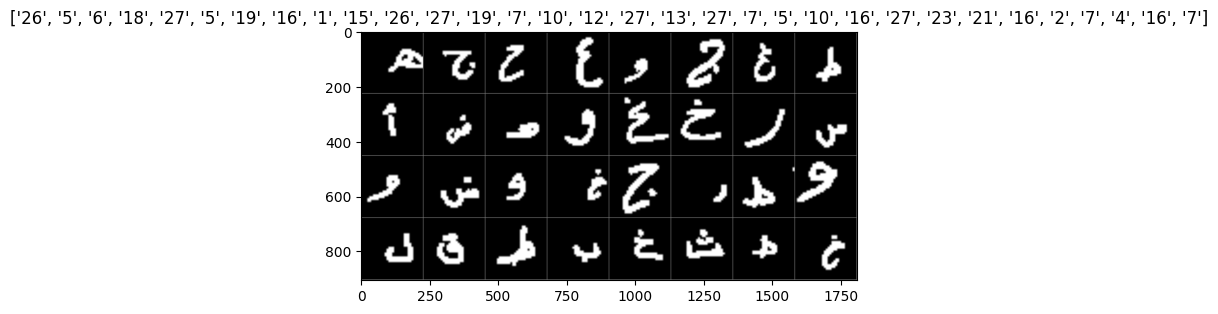

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    # --- FIX IS HERE ---
    # Use the same stats you used in data_transforms!
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    # -------------------

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Run it again to see cleaner images
inputs, classes = next(iter(dataloaders[TRAIN_DIR_NAME]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in [TRAIN_DIR_NAME, TEST_DIR_NAME]:
                if phase == TRAIN_DIR_NAME:
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == TRAIN_DIR_NAME):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == TRAIN_DIR_NAME:
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == TRAIN_DIR_NAME:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == TEST_DIR_NAME and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
model_conv_1 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv_1.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_1.fc.in_features
model_conv_1.fc = nn.Linear(num_ftrs, 28)

model_conv = model_conv_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv_1 = train_model(model_conv_1, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Train Arabic Loss: 2.3676 Acc: 0.4225
Test Arabic Loss: 1.6636 Acc: 0.6467

Epoch 1/24
----------
Train Arabic Loss: 1.4924 Acc: 0.6592
Test Arabic Loss: 1.2687 Acc: 0.6866

Epoch 2/24
----------
Train Arabic Loss: 1.2097 Acc: 0.7105
Test Arabic Loss: 1.0699 Acc: 0.7313

Epoch 3/24
----------
Train Arabic Loss: 1.0650 Acc: 0.7345
Test Arabic Loss: 0.9813 Acc: 0.7393

Epoch 4/24
----------
Train Arabic Loss: 0.9684 Acc: 0.7510
Test Arabic Loss: 0.9010 Acc: 0.7557

Epoch 5/24
----------
Train Arabic Loss: 0.9035 Acc: 0.7629
Test Arabic Loss: 0.8584 Acc: 0.7682

Epoch 6/24
----------
Train Arabic Loss: 0.8539 Acc: 0.7763
Test Arabic Loss: 0.8125 Acc: 0.7685

Epoch 7/24
----------
Train Arabic Loss: 0.8126 Acc: 0.7917
Test Arabic Loss: 0.7991 Acc: 0.7747

Epoch 8/24
----------
Train Arabic Loss: 0.8104 Acc: 0.7909
Test Arabic Loss: 0.7998 Acc: 0.7756

Epoch 9/24
----------
Train Arabic Loss: 0.8066 Acc: 0.7890
Test Arabic Loss: 0.7974 Acc: 0.7762

Epoch 10/24
--------

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12)) # Made the figure larger for clarity

    with torch.no_grad():
        # Using TEST_DIR_NAME to check against unseen data
        for i, (inputs, labels) in enumerate(dataloaders[TEST_DIR_NAME]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                # 1. Get the names
                predicted_name = class_names[preds[j]]
                actual_name = class_names[labels[j]]

                # 2. Pick a color (Green if correct, Red if wrong)
                if predicted_name == actual_name:
                    color = 'green'
                else:
                    color = 'red'

                # 3. Set the title with both
                ax.set_title(f'Pred: {predicted_name}\nActual: {actual_name}', color=color)

                # Display the image
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



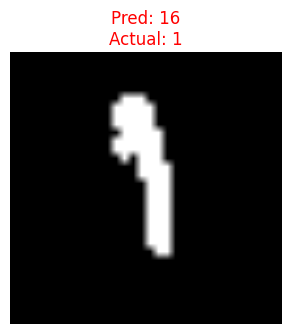

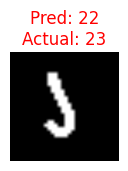

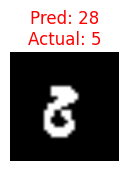

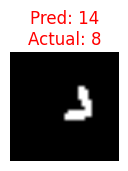

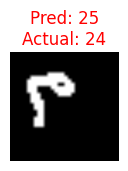

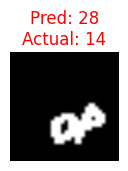

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
# 1. Load the model
model_conv_2 = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# 1: DO NOT FREEZE LAYERS ---

# 2. Update the final layer for Arabic classes (28 classes)
num_ftrs = model_conv_2.fc.in_features
# Use len(class_names) to be safe, or 28 if you are certain
model_conv_2.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_conv_2.to(device)

criterion = nn.CrossEntropyLoss()

# --- CRITICAL CHANGE 2: OPTIMIZE ALL PARAMETERS ---
# pass 'model_ft.parameters()', NOT 'model_ft.fc.parameters()'
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_conv_2 = train_model(model_conv_2, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Train Arabic Loss: 0.9991 Acc: 0.7735
Test Arabic Loss: 0.3009 Acc: 0.9274

Epoch 1/24
----------
Train Arabic Loss: 0.2207 Acc: 0.9493
Test Arabic Loss: 0.1828 Acc: 0.9521

Epoch 2/24
----------
Train Arabic Loss: 0.1379 Acc: 0.9649
Test Arabic Loss: 0.1548 Acc: 0.9554

Epoch 3/24
----------
Train Arabic Loss: 0.0863 Acc: 0.9807
Test Arabic Loss: 0.1388 Acc: 0.9589

Epoch 4/24
----------
Train Arabic Loss: 0.0618 Acc: 0.9882
Test Arabic Loss: 0.1306 Acc: 0.9613

Epoch 5/24
----------
Train Arabic Loss: 0.0445 Acc: 0.9914
Test Arabic Loss: 0.1316 Acc: 0.9628

Epoch 6/24
----------
Train Arabic Loss: 0.0307 Acc: 0.9953
Test Arabic Loss: 0.1224 Acc: 0.9673

Epoch 7/24
----------
Train Arabic Loss: 0.0209 Acc: 0.9981
Test Arabic Loss: 0.1226 Acc: 0.9649

Epoch 8/24
----------
Train Arabic Loss: 0.0180 Acc: 0.9987
Test Arabic Loss: 0.1204 Acc: 0.9667

Epoch 9/24
----------
Train Arabic Loss: 0.0178 Acc: 0.9984
Test Arabic Loss: 0.1186 Acc: 0.9670

Epoch 10/24
--------

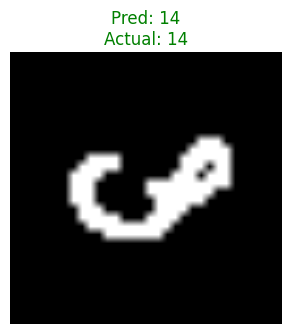

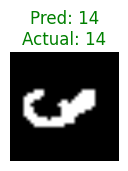

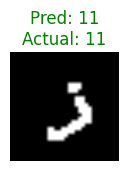

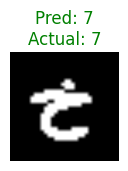

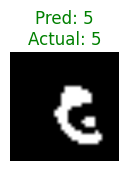

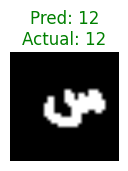

In [ ]:
visualize_model(model_conv_2)

plt.ioff()
plt.show()

In [ ]:
_

''